
# Food.com and Twitter Classification

# Importing Libraries

In [ ]:
## Processing and Visualization
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap
import seaborn as sns
import nltk
import string
import re
import os
from absl import logging
from scipy.stats import multivariate_normal as mvn
from wordcloud import WordCloud



## NLTK
from nltk import word_tokenize
nltk.download('stopwords')
from nltk.corpus import stopwords
from nltk.stem.porter import PorterStemmer
from nltk import pos_tag # part of speech if a known etc


## Tensorflow 
import tensorflow as tf
import tensorflow_hub as hub
from tensorflow import keras
from tensorflow.keras import layers

## SKLEarn
from sklearn.model_selection import train_test_split

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


# Initializing Modeling Definitions

### Logistic Regression

In [ ]:
 def sigmoidLR(h):
    return 1/(1 + np.exp(-h))

def cross_entropyLR(y, p_hat):
    return -(1/len(y))*np.sum(y*np.log(p_hat) + (1-y)*np.log(1 - p_hat))

def accuracyLR(y, y_hat):
    return np.mean(y == y_hat)

class LogisticRegression():
    def __init__(self, thresh = 0.5):
        self.thresh = thresh
        self.w = None
        self.b = None
        
    def fit(self, X, y, eta = 1e-3, epochs = 1e3, show_curve = False):
        epochs = int(epochs)
        N, D = X.shape
        
        self.w = np.random.randn(D)
        self.b = np.random.randn(1)
        
        J = np.zeros(epochs)
        
        for epoch in range(epochs):
            p_hat = self.__forward(X)
            J[epoch] = cross_entropyLR(y, p_hat)
            
            self.w -= eta*(1/N)*X.T@(p_hat - y)
            self.b -= eta*(1/N)*np.sum(p_hat - y)
        
        if show_curve:
            plt.figure()
            plt.plot(J)
            plt.xlabel("epochs")
            plt.ylabel("$\mathcal{J}$")
            plt.title("TrainingCurve")
            plt.show()
            
    def __forward(self, X):
        return sigmoidLR(X@self.w + self.b)
    
    def predict(self, X):
        return (self.__forward(X) >= self.thresh).astype(np.int32)


#
# Running Code
#
# lr = LogisticRegression() 
# lr.fit(X, y, show_curve = True, epochs = 15000, eta = 0.2)

### ANN

In [ ]:
#cmap_bold = ListedColormap(["#FF0000", "#00FF00", "#0000FF"])
#cmap_light = ListedColormap(["#FFBBBB", "#BBFFBB", "#BBBBFF"])

def linear(H):
  return H 

def ReLU(H):
  return H*(H > 0)

def sigmoid(H):
  return 1/(1 + np.exp(-H))

def softmax(H):
  eH = np.exp(H)
  return eH/eH.sum(axis = 1, keepdims = True)

def cross_entropy(Y, P_hat):
  return -(1/len(Y))*np.sum(Y*np.log(P_hat))

def OLS(Y, Y_hat):
  return (1/(2*len(Y)))*np.sum((Y - Y_hat)**2)

def one_hot_encode(y):
    N = len(y)
    K = len(set(y))
    Y = np.zeros((N, K))
    
    for i in range(N):
        Y[i, y[i]] = 1
    
    return Y

def accuracy(y, y_hat):
  return np.mean(y == y_hat)

def R2(y, y_hat):
  return 1 - np.sum((y - y_hat)**2)/np.sum((y - y.mean())**2)

def derivative(Z, a):
  if a == linear:
    return 1
  elif a == sigmoid:
    return Z*(1 - Z)
  elif a == np.tanh:
    return 1 - Z*Z
  elif a == ReLU:
    return (Z > 0).astype(int)
  else:
    ValueError("Unknown Activation Function")

###
###
### ANN Definition 
###
###

class ANN():

  def __init__(self, architecture, activations = None, mode = 0):
    self.mode = mode
    self.architecture = architecture
    self.activations = activations
    self.L = len(architecture) + 1

  def fit(self, X, y, eta = 1e-3, epochs = 1e3, show_curve = False):
    epochs = int(epochs)

    if self.mode:
      Y = y
    else:
      Y = one_hot_encode(y)
    
    N, D = X.shape
    K = Y.shape[1]

    #Weights and Bias initializations

    self.W = {l: np.random.randn(M[0], M[1]) for l, M in enumerate (zip(([D] + self.architecture), (self.architecture + [K])), 1)}

    self.b = {l: np.random.randn(M) for l, M in enumerate(self.architecture + [K], 1)}

    # Activation Funtion Loading
    if self.activations is None:
      self.a = {l: ReLU for l in range(1, self.L)}
    else:
      self.a = {l: act for l, act in enumerate(self.activations, 1)}
    
    # Mode Set
    if self.mode:
      self.a[self.L] = linear
    else:
      self.a[self.L] = softmax

    J = np.zeros(epochs)

    #Gradient Descent
    for epoch in range(epochs):
      self.forward(X)
      if self.mode:
        J[epoch] = OLS(Y, self.Z[self.L])
      else:
        J[epoch] = cross_entropy(Y, self.Z[self.L])

      dH = (1/N)*(self.Z[self.L] - Y)
      
      #Weight and Bias Update Rules
      for l in sorted(self.W.keys(), reverse = True):
        dW = self.Z[l - 1].T@dH
        db = dH.sum(axis = 0)

        self.W[l] -= eta*dW
        self.b[l] -= eta*db
      
        if l > 1:
          dZ = dH@self.W[l].T
          dH = dZ*derivative(self.Z[l - 1], self.a[l - 1])
      
    if show_curve:
      plt.figure()
      plt.plot(J)
      plt.xlabel("epochs")
      plt.ylabel("$\mathcal{J}$")
      plt.title("Training Curve")
      plt.show()

  def forward(self, X):
    self.Z = {0: X}

    for l in sorted(self.W.keys()):
      self.Z[l] = self.a[l](self.Z[l - 1]@self.W[l] + self.b[l])

  def predict(self, X):
    self.forward(X)

    if self.mode:
      return self.Z[self.L]
    else:
      return self.Z[self.L].argmax(axis = 1)   

### KNN

In [ ]:
class KNNClassifier():
    def fit(self, X, y):
        self.X=X
        self.y=y
        
    def predict(self, X, K, epsilon=1e-3):
        
        N=len(X)
        
        y_hat=np.zeros(N)
        
        for i in range(N):
            
            dist2=np.sum((self.X-X[i])**2, axis=1)
            
            idxt=np.argsort(dist2)[:K]
            
            gamma_k=1/(np.sqrt(dist2[idxt])+epsilon)
            
            y_hat[i]= np.bincount(self.y[idxt], weights=gamma_k).argmax()
            
        return y_hat

### K-Means

In [ ]:
def Responsibility(X, means, beta = 1e-3, *args, **kwargs):
  diff = []
  responsibilities = []

  for mean in means:
    diff = X - mean
    dist = (np.sum(diff**2, axis = 1, keepdims = True))

    numerator = np.exp(-beta*dist)
    denominator = np.sum(numerator)

    responsibility = -numerator/denominator

    responsibilities.append(responsibility)
  return np.hstack(responsibilities)

def Distance(x, means, *args, **kwargs):
  diff = []
  dists = []
  for mean in means:
    diff = x - mean
    dist = np.sqrt(np.sum(diff**2, axis = 1, keepdims = True))
    dists.append(dist)

  return np.hstack(dists)

class K_Means:
  def __init__(self, k, distance_func = Distance, beta = None):
    self.k = k
    self.distance_func = distance_func
    self.beta = beta

  def Fit(self, X, iterations = 5):
    indices = np.arange(X.shape[0])
    sample_indices = np.random.choice(indices, size = self.k, replace = False)
    self.means = X[sample_indices]

    for i in range(iterations):
      y_hat = self.Predict(X)
      self.means = []
      for j in range(self.k):
        mean = np.mean(X[y_hat == j], axis = 0)
        self.means.append(mean)
      self.means = np.vstack(self.means)

    y_hat = self.Predict(X)
    #plt.figure(figsize = (10, 7))
    #plt.scatter(X[:, 0], X[:, 1], c = y_hat, s = 1)
    #plt.scatter(self.means[:, 0], self.means[:, 1], c = 'k', s = 15)

    return y_hat

  def Predict(self, X):
    dist = self.distance_func(X, self.means, self.beta)
    y_hat = np.argmin(dist, axis = 1)

    return y_hat


# softK=K_Means(5, distance_func= Responsibilty, beta=1.4)
# softK.Fit(X, iterations=8)

### Bayesian Classifiers

#### Bernoulli Classifier 

In [ ]:
class BernNB():
    def fit(self, X, y, epsilon = 1e-2):
        N, D = X.shape
        self.likelihoods = dict()
        self.priors = dict()
        self.K = set(y.astype(int))
        
        for k in self.K:
            X_k = X[y == k, :]
            p = (sum(X_k) + 1) / (len(X_k) + 2)
            self.likelihoods[k] = {'mean': p, 'cov': p* (1 - p) + epsilon}
            self.priors[k] = len(X_k)/len(X)
            
    def predict(self, X):
        N, D = X.shape
        P_hat = np.zeros((N, len(self.K)))
        
        for k, l in self.likelihoods.items():
            # using the Bernoulli function (get matrix to go from m x n to 1 x 1 for each k)
            P_hat[:, k] = np.log(self.priors[k]) + np.matmul(X, np.log(l['mean'])) + np.matmul((1 - X), np.log(abs(1 - l['mean'])))
            
        return P_hat.argmax(axis = 1)

# How to run: 

#bnb=BernNB()
#bnb.fit(X_train, y_train)
#y_hat=bnb.predict(X_test)
#print(accuracy(y_test, y_hat)) # using a new accuracy definition

#### Gaussian Bayes 

In [ ]:
class GaussBayes():
    def fit(self, X, y, epsilon = 1e-3):
        self.likelihoods = dict()
        self.priors = dict()
        
        self.K = set(y.astype(int))
        
        for k in self.K:
            X_k = X[y == k,:]
            N_k, D = X_k.shape
            mu_k=X_k.mean(axis=0)
            self.likelihoods[k] = {"mean":X_k.mean(axis=0), "cov":(1/(N_k-1))*np.matmul((X_k-mu_k).T,X_k-mu_k)+ epsilon*np.identity(D)}
            self.priors[k] = len(X_k)/len(X)
            
    def predict(self, X):
        N, D = X.shape
        
        P_hat = np.zeros((N,len(self.K)))
        
        for k, l in self.likelihoods.items():
            P_hat[:,k] = mvn.logpdf(X, l["mean"], l["cov"]) + np.log(self.priors[k])
            
        return P_hat.argmax(axis = 1)

#gnb = GaussBayes()
#gnb.fit(X,y)
#y_hat = gnb.predict(X)
#plt.figure()
#plt.scatter(X[:,0], X[:,1], c = y_hat, alpha = 0.25)

#### Gaussian Naive Bayes 

In [ ]:
class GaussNB():
    def fit(self, X, y, epsilon = 1e-3):
        self.likelihoods = dict()
        self.priors = dict()
        
        self.K = set(y.astype(int))
        
        for k in self.K:
            X_k = X[y == k,:]
            self.likelihoods[k] = {"mean":X_k.mean(axis=0), "cov":X_k.var(axis=0) + epsilon}
            self.priors[k] = len(X_k)/len(X)
            
    def predict(self, X):
        N, D = X.shape
        
        P_hat = np.zeros((N,len(self.K)))
        
        for k, l in self.likelihoods.items():
            P_hat[:,k] = mvn.logpdf(X, l["mean"], l["cov"]) + np.log(self.priors[k])
        return P_hat.argmax(axis = 1)

#gnb = GaussNB()
#gnb.fit(X,y)
#y_hat = gnb.predict(X)

#plt.figure()
#plt.scatter(X[:,0], X[:,1], c = y_hat, alpha = 0.25)

# Metrics

In [ ]:
def accuracy(y,y_hat):
    return np.mean(y == y_hat)

def conf_matrix(y_test, y_hat):
    import pandas as pd
    import seaborn as sb
    import matplotlib.pyplot as plt
    
    lt1 = []
    for i in y_test:
        lt1.append(i)
        
    lt2 = []
    for i in y_hat:
        lt2.append(i)
    
    
    positive = 0
    negative = 0
    false_positive = 0
    false_negative = 0
    for x, y in zip(lt1, lt2):        
        
        if x == 0 and y == 1:
            false_positive += 1

        elif x == 1 and y == 0:
            false_negative += 1
            
        elif x == 1 and y == 1:
            positive += 1
        
        elif x == 0 and y == 0:
            negative += 1
            
    precision = positive/(positive + false_positive)
    recall =  positive/(positive + false_negative)
    f1 = 2*(recall*precision)/(recall+precision)
    
    print('---------------------------------')
    print(f"Accuracy : {accuracy(y_test,y_hat):0.3f}")
    print('Precision: ', precision )
    print('Recall: ', recall ) 
    print('F1 - Score: ', f1) 
    print('---------------------------------')
    print('Positives: ', positive)   
    print('Negative: ', negative)
    print('False Positives: ', false_positive)
    print('False Negatives: ', false_negative)
    print('---------------------------------')
    
    pos = [positive, false_positive]
    neg = [false_negative, negative]

    data_conf = {'0': neg, '1': pos}
    df = pd.DataFrame(data_conf, columns = ['0', '1'])

    plt.figure(figsize = (15,5))
    cm = sns.heatmap(df.T, annot = True, cmap = "Greens", fmt = 'g')
    cm.set_xticklabels(['1', '0'])
    cm.invert_yaxis()
    cm.set_yticklabels(['0', '1'])
    cm.set_xticklabels(cm.get_xmajorticklabels(), fontsize = 15)
    cm.set_yticklabels(cm.get_ymajorticklabels(), fontsize = 15)
    plt.title("Confusion Matrix", fontsize = '25')
    plt.xlabel('True Labels', fontsize = '20')
    plt.ylabel('Predictions', fontsize = '20')
    plt.show()
 

# Text Cleaning


## Twitter

In [ ]:
def twitter_data():
  from google.colab import drive
  drive.mount('/content/drive')

  df = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/Ugly_Words_labeled.csv', header=None)

  df.columns = ['tweet', 'label','flip']

  print(df.label.value_counts())

  print(df[df.tweet.isnull()])

  df.iloc[342, 1] = 1.0
  df.iloc[464, 1] = 0.0
  print(df[df.label.isnull()])

  df.flip = df.flip.replace(np.nan, 0.0)
  print(df.flip.unique())

  df.dropna(inplace = True)

  print(df.shape)
  return df

In [ ]:
# Defining embedder
module_url = "https://tfhub.dev/google/universal-sentence-encoder/4"
model = hub.load(module_url)
print ("module %s loaded" % module_url)

def embed(input):
  return model(input)

module https://tfhub.dev/google/universal-sentence-encoder/4 loaded


In [ ]:
def cleaned_tweet(X, y):
  # Making all the tweets lower case
  for row in range(X.shape[0]):
    X.iloc[row] = X.iloc[row].lower()
  
  # Remove urls
  X_http = []
  for row in X:
    X_http.append(re.sub(r'http\S+', '', row))

  # Remove punctuation
  X0 = []
  for row in X_http:
    X0.append("".join([ char for char in row if char not in string.punctuation]))
  
  # Splitting data into training/testing
  train, test = train_test_split(X0, test_size = 0.3, train_size = 0.7, random_state = None, shuffle = False, stratify = None)

  size = int(X.shape[0]*0.7)
  y_train = y[:size]
  y_test = y[size:]

  train_embeddings = embed(train)
  test_embeddings = embed(test)

  X_train = train_embeddings.numpy()
  X_test = test_embeddings.numpy()

  return X_train, X_test, y_train.to_numpy().astype(int), y_test.to_numpy().astype(int)

## Recipes

In [ ]:
def recipe_data(X_food, y_food):
  X1 = embed(X_food['name'].to_numpy())
  X2 = embed(X_food['ingridents'].to_numpy())

  steps = []
  for i in range(len(X_food['steps'].to_numpy())):
    steps.append(str((X_food['steps'].to_numpy())[i]))

  X3 = embed(steps)

  food = np.hstack((X1, X2, X3))

  # Splitting data into training/testing
  ind = list(range(y_food.shape[0]))  # making a list of the indices for the rows
  split = int(0.7 * y_food.shape[0])  # getting 80% of the rows
  np.random.shuffle(ind)  # randomly shuffling the indices

  ind_train = ind[:split]  # taking the first 80% of the random indices of the data
  ind_test = ind[split:]  # taking the remaining 20% of the indices

  new = X2.numpy()
  X1_train = new[ind_train]
  X1_test = new[ind_test]

  #X1_train = food[ind_train]
  y1_train = y_food[ind_train]
  #X1_test = food[ind_test]
  y1_test = y_food[ind_test]

  return X1_train, X1_test, y1_train, y1_test

# Data Wrangling

## Twitter Data

In [ ]:
df = twitter_data()

Mounted at /content/drive
0.0    1168
1.0     694
Name: label, dtype: int64
     tweet  label  flip
1733   NaN    0.0   NaN
Empty DataFrame
Columns: [tweet, label, flip]
Index: []
[0. 1.]
(1863, 3)


In [ ]:
# Separating the tweet and labels 
y = df['label']
X = df['tweet']

In [ ]:
X_train, X_test, y_train, y_test = cleaned_tweet(X, y)

/usr/local/lib/python3.6/dist-packages/pandas/core/indexing.py:670: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  iloc._setitem_with_indexer(indexer, value)


## Recipes Data

In [ ]:
data = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/data_recipes.csv')

data['rating'] = data.iloc[:,1].replace([0,1,2,3],0, regex = True)
data['rating'] = data.iloc[:,1].replace([4,5],1, regex = True)

In [ ]:
X_food = data[['name', 'ingridents', 'steps']]
y_food = data['rating']

In [ ]:
X1_train, X1_test, y1_train, y1_test = recipe_data(X_food, y_food)

# Modeling
Here we post main functions of the best models

## Twitter Main

In [ ]:
gnb = GaussNB()
gnb.fit(X_train, y_train)
y_gnb = gnb.predict(X_test)

In [ ]:
tweet_gnb = accuracy(y_test, y_gnb)
tweet_gnb

0.8389982110912343

In [ ]:
gb = GaussBayes()
gb.fit(X_train, y_train)
y_gb = gb.predict(X_test)

In [ ]:
tweet_gb = accuracy(y_test, y_gb)
tweet_gb

0.813953488372093

In [ ]:
bnb = BernNB()
bnb.fit(X_train, y_train)
y_bnb = bnb.predict(X_test)

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:20: RuntimeWarning: invalid value encountered in log


In [ ]:
tweet_bnb = accuracy(y_test, y_bnb)
tweet_bnb

0.6368515205724508

In [ ]:
knn = KNNClassifier()
knn.fit(X_train, y_train)
y_knn = knn.predict(X_test, 10)

In [ ]:
tweet_knn = accuracy(y_test, y_knn)
tweet_knn

0.815742397137746

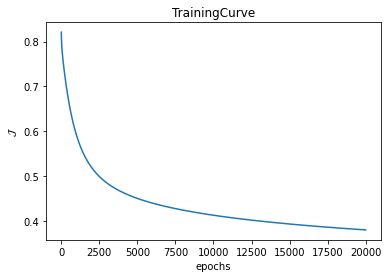

In [ ]:
log_reg = LogisticRegression()
log_reg.fit(X_train, y_train, eta = 1e-1, epochs = 2e4, show_curve = True)
y_logreg = log_reg.predict(X_test)

In [ ]:
tweet_lr = accuracy(y_test, y_logreg)
tweet_lr

0.8300536672629696

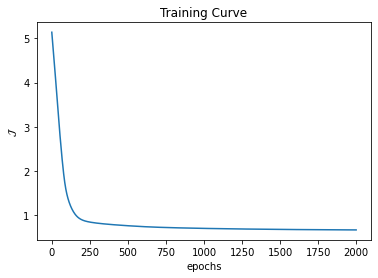

In [ ]:
myANN = ANN(architecture = [16, 8, 8, 16], activations = [ReLU, np.tanh, np.tanh, np.tanh])
myANN.fit(X_train, y_train, eta = 2e-3, epochs = 2e3, show_curve = True)
y_ann = myANN.predict(X_test)

In [ ]:
tweet_ann = accuracy(y_test, y_ann)
tweet_ann

0.6189624329159212

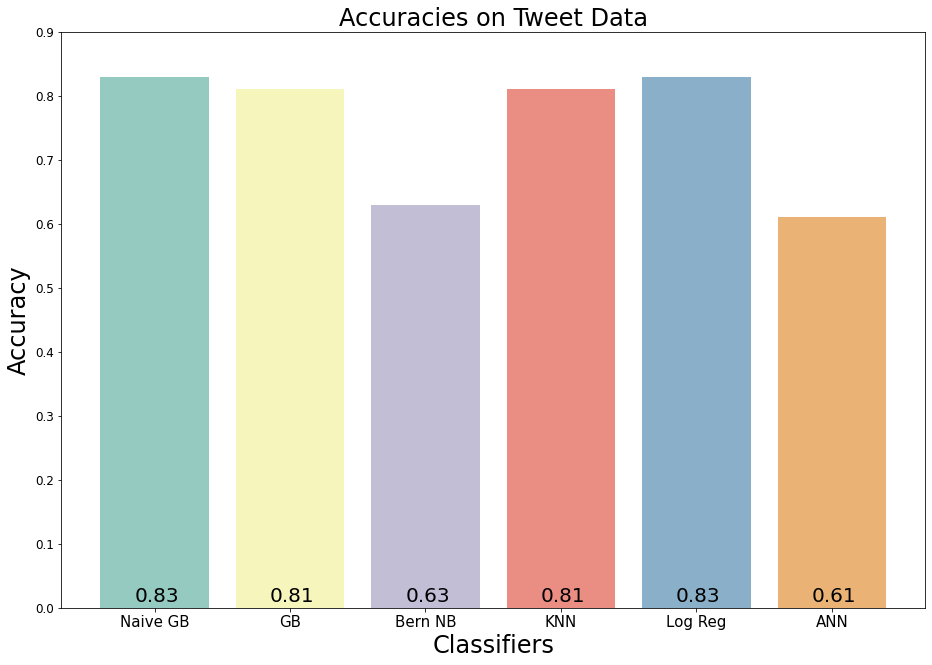

In [ ]:
tweet_acc = [tweet_gnb, tweet_gb, tweet_bnb, tweet_knn, tweet_lr, tweet_ann]
for i in range(len(tweet_acc)):
  tweet_acc[i] = int(tweet_acc[i]*100)/100

# generating the figure
fig = plt.figure(figsize = (12, 8))
ax = fig.add_axes([0, 0, 1, 1])  # generating axes
fig_labels = ["Naive GB", "GB", "Bern NB", "KNN", "Log Reg", "ANN"]  # labeling the xticks
label_color_list = ['#95CAC1', '#F6F6BC', '#C1BED6', '#EA8D83', '#8AAFC9', '#EAB375']  # assigning method to a different color
ax.bar(fig_labels, tweet_acc, color = label_color_list)  # plotting bar graph

# adjusting the axes
ax.set_xlabel('Classifiers')
ax.set_ylabel('Accuracy')
ax.set_yticks(np.arange(0, 1, 0.1))
ax.tick_params(axis ='x', which = 'major', labelsize = 15)
ax.tick_params(axis ='y', which = 'major', labelsize = 12)
ax.set_title('Accuracies on Tweet Data')

# changing the font size of the axes
for item in ([ax.title, ax.xaxis.label, ax.yaxis.label]):
    item.set_fontsize(24)

# placing the numbers in the bar graph
for i, v in enumerate(tweet_acc):
    ax.text(i-0.15, 
              v/tweet_acc[i]-0.99, 
              tweet_acc[i],
              fontsize=20)

plt.show()  # viewing the plot

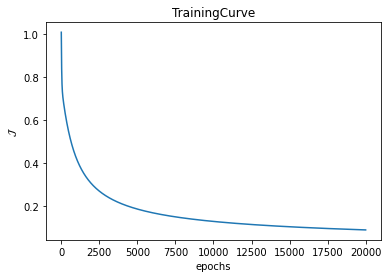

---------------------------------
Accuracy : 0.943
Precision:  0.9913419913419913
Recall:  0.8841698841698842
F1 - Score:  0.9346938775510205
---------------------------------
Positives:  229
Negative:  298
False Positives:  2
False Negatives:  30
---------------------------------


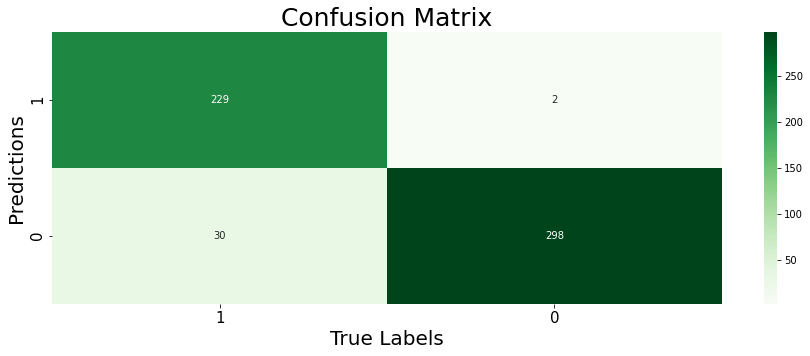

In [ ]:
softK = K_Means(2, distance_func = Responsibility, beta = 1.4)
softK.Fit(X_train, iterations = 8)

y_km_train = softK.Predict(X_train)
y_km_test = softK.Predict(X_test)

log_reg1 = LogisticRegression()
log_reg1.fit(X_train, y_km_train, eta = 1e-1, epochs = 2e4, show_curve = True)
y_logreg1 = log_reg1.predict(X_test)

conf_matrix(y_km_test, y_logreg1)

#### Twitter EDA

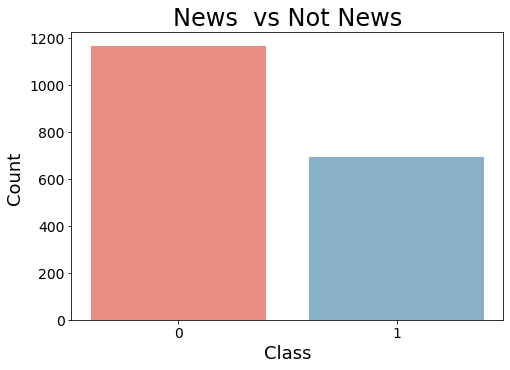

In [ ]:
fig = plt.figure()
ax = fig.add_axes([0,0,1,1])
Class_type = ['0', '1']
Count = [1168 , 694]
ax.bar( Class_type, Count, color=["#EA8D83","#8AAFC9"])
plt.title('News  vs Not News', fontsize = 24)
plt.xlabel('Class', fontsize = 18)
plt.ylabel('Count ', fontsize = 18)
plt.setp(ax.get_yticklabels(), fontsize = 14)
plt.setp(ax.get_xticklabels(), fontsize = 14)
#plt.ylim(0,100)
plt.show()

### Twitter Word Cloud

In [ ]:
# Getting the number where the twitter data was split
size = int(X.shape[0]*0.7)

# Making separte version of the tweet train
t_train = X.iloc[:size]

# Making a separate version of the tweet test
# We're looking at the test data because the model 
# used this dataset predict wether a tweet is news or not
t_test = X.iloc[size:]
t_test = t_test.to_numpy() # then converting to numpy for usability 

# 
#
# THE MAGIC HAPPENS HERE
#
# After using the model to predict news/not news, the values are saved in 
# y_hat. So we use list comprehension and GO BACK to the test data
# and extract all the tweets that are labeled 0 or 1, for news or not news 
#
news = t_test[y_gnb == 1]
not_news = t_test[y_gnb == 0]


news_string = ''
for i in range(len(news)):
  news_string += news[i]

not_news_string = ''
for i in range(len(not_news)):
  not_news_string += not_news[i]

##### Not News

(-0.5, 399.5, 199.5, -0.5)

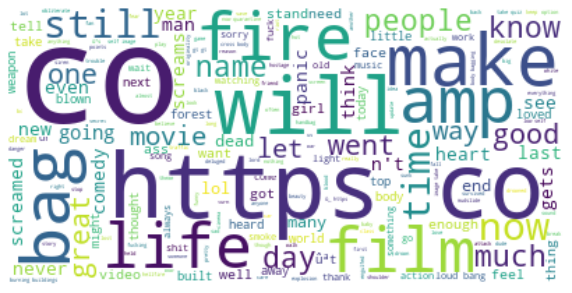

In [ ]:
# Generate a word cloud image
wordcloud = WordCloud(background_color='white').generate(not_news_string)

# Display the generated image:
# the matplotlib way:
import matplotlib.pyplot as plt
plt.figure(figsize=(10,8))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis("off")

##### News 

(-0.5, 399.5, 199.5, -0.5)

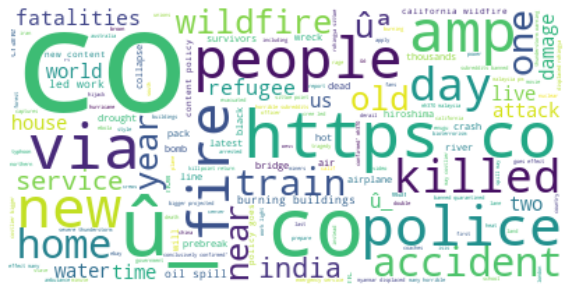

In [ ]:
  # Generate a word cloud image
wordcloud = WordCloud(background_color='white').generate(news_string)

# Display the generated image:
# the matplotlib way:
import matplotlib.pyplot as plt
plt.figure(figsize=(10,8))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis("off")

## Recipes Main

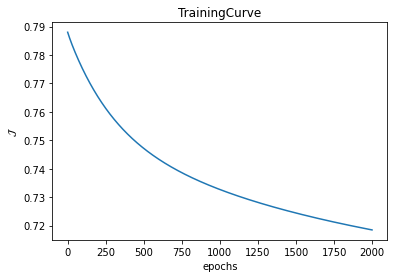

In [ ]:
log_reg2 = LogisticRegression()
log_reg2.fit(X1_train, y1_train, eta = 1e-1, epochs = 2e3, show_curve = True)
y_logreg2 = log_reg2.predict(X1_test)

In [ ]:
food_lr = accuracy(y1_test, y_logreg2)
food_lr

0.5283333333333333

---------------------------------
Accuracy : 0.528
Precision:  0.5247813411078717
Recall:  0.5287452790600083
F1 - Score:  0.5267558528428093
---------------------------------
Positives:  1260
Negative:  1276
False Positives:  1141
False Negatives:  1123
---------------------------------


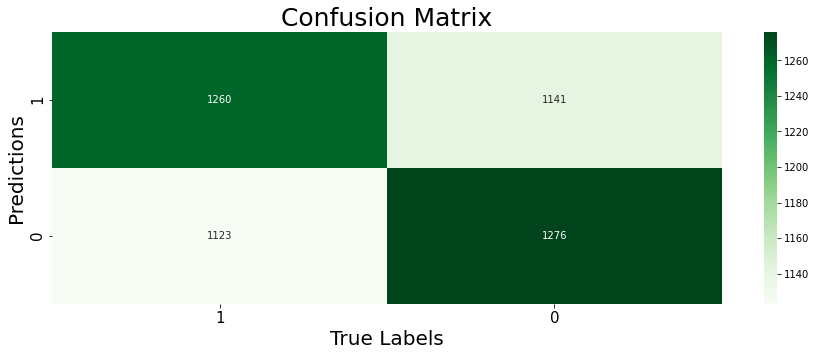

In [ ]:
conf_matrix(y1_test, y_logreg2)

In [ ]:
softK1 = K_Means(2, distance_func = Responsibility, beta = 1.4)
softK1.Fit(X1_train, iterations = 8)

y1_km_train = softK1.Predict(X1_train)
y1_km_test = softK1.Predict(X1_test)

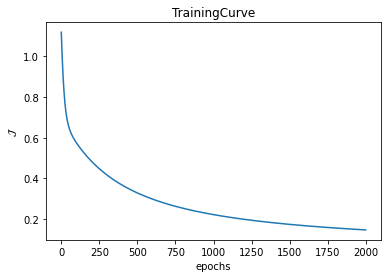

In [ ]:
# Logistic Regression with KMeans Labels
log_reg3 = LogisticRegression()
log_reg3.fit(X1_train, y1_km_train, eta = 1e-1, epochs = 2e3, show_curve = True)
y_logreg3 = log_reg3.predict(X1_test)

In [ ]:
food_kmeans = accuracy(y1_km_test, y_logreg3)
food_kmeans

0.9702083333333333

---------------------------------
Accuracy : 0.970
Precision:  0.9561009332872451
Recall:  0.9942487419122933
F1 - Score:  0.9748017621145374
---------------------------------
Positives:  2766
Negative:  1891
False Positives:  127
False Negatives:  16
---------------------------------


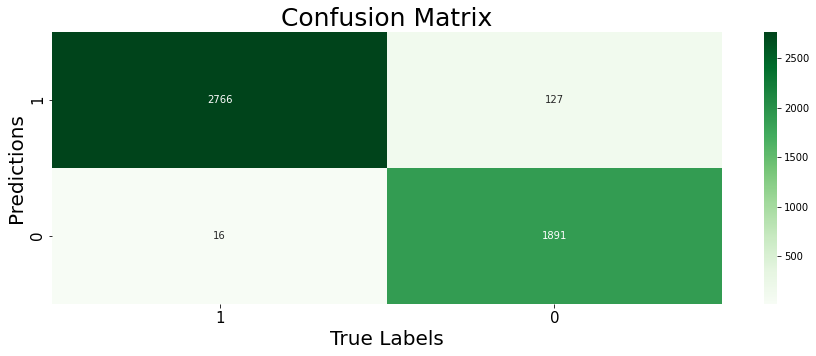

In [ ]:
conf_matrix(y1_km_test, y_logreg3)

In [ ]:
gnb1 = GaussNB()
gnb1.fit(X1_train, y1_train)
y1_gnb = gnb1.predict(X1_test)

In [ ]:
food_gnb = accuracy(y1_test, y1_gnb)
food_gnb

0.5514583333333334

---------------------------------
Accuracy : 0.551
Precision:  0.5402943237561317
Recall:  0.6470835081829627
F1 - Score:  0.5888867672331487
---------------------------------
Positives:  1542
Negative:  1105
False Positives:  1312
False Negatives:  841
---------------------------------


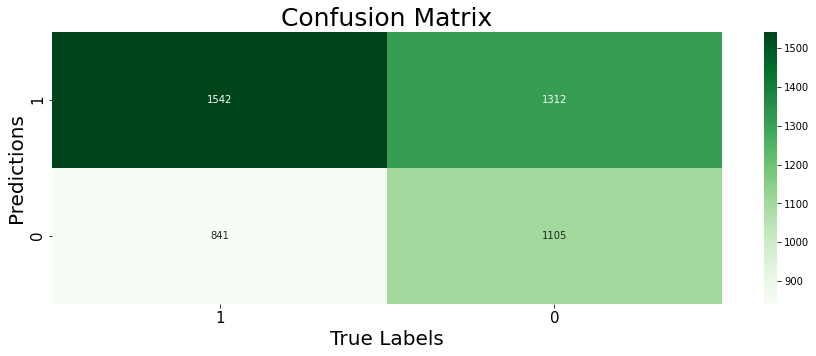

In [ ]:
conf_matrix(y1_test, y1_gnb)

---------------------------------
Accuracy : 0.547
Precision:  0.5416859300354446
Recall:  0.6257788855260815
F1 - Score:  0.5807037832479762
---------------------------------
Positives:  3515
Negative:  2609
False Positives:  2974
False Negatives:  2102
---------------------------------


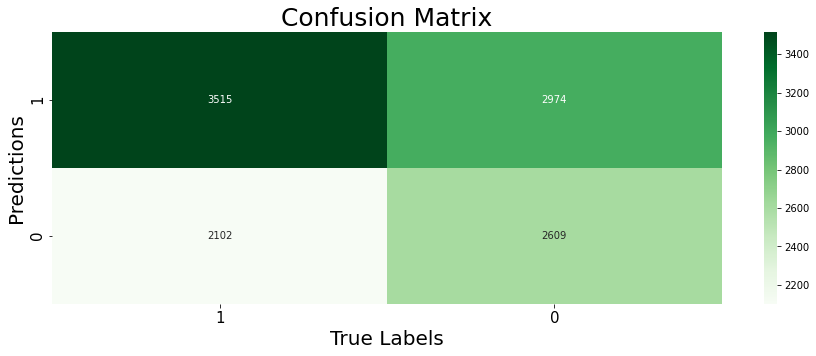

In [ ]:
conf_matrix(y1_train, y1_km_train)  # comparing KMeans training labels with human labels

---------------------------------
Accuracy : 0.537
Precision:  0.5287562904385334
Recall:  0.6172891313470416
F1 - Score:  0.5696030977734754
---------------------------------
Positives:  1471
Negative:  1106
False Positives:  1311
False Negatives:  912
---------------------------------


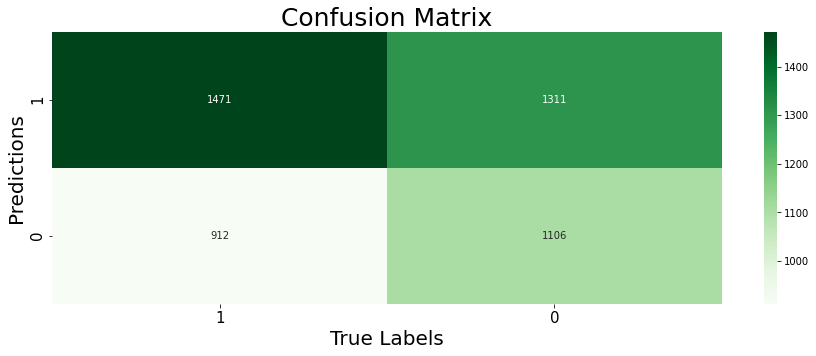

In [ ]:
conf_matrix(y1_test, y1_km_test)  # comparing KMeans testing labels with human labels

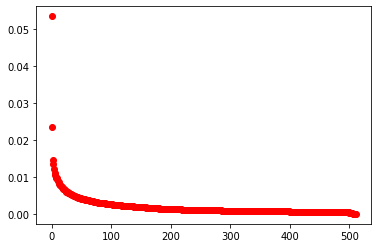

In [ ]:
u, s, v = np.linalg.svd(X1_train, full_matrices = False)

plt.figure()
plt.plot(s/np.sum(s), 'ro')
plt.show()

In [ ]:
s = np.diag(s)

U = u
S = s[:, :2]
V = v[:, :2].T

In [ ]:
new = np.matmul(np.matmul(U, S), V)

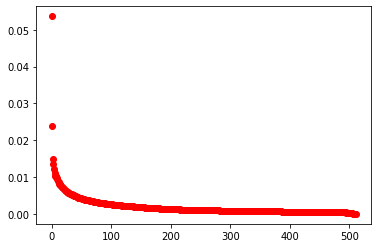

In [ ]:
u0, s0, v0 = np.linalg.svd(X1_test, full_matrices = False)

plt.figure()
plt.plot(s0/np.sum(s0), 'ro')
plt.show()

In [ ]:
s0 = np.diag(s0)

U0 = u0
S0 = s0[:, :2]
V0 = v0[:, :2].T

In [ ]:
new0 = np.matmul(np.matmul(U0, S0), V0)

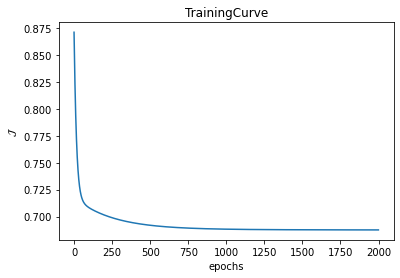

In [ ]:
# Logistic Regression with SVD truncated recipe data
svd = LogisticRegression()
svd.fit(new, y1_train, eta = 1e-1, epochs = 2e3, show_curve = True)
y_svd = svd.predict(new0)

In [ ]:
food_svd = accuracy(y1_test, y_svd)
food_svd

0.5035416666666667

In [ ]:
# conf_matrix(y1_test, y_svd)

ZeroDivisionError: ignored

In [ ]:
gb1 = GaussBayes()
gb1.fit(X1_train, y1_train)
y_gb1 = gb1.predict(X1_test)

In [ ]:
food_gb = accuracy(y1_test, y_gb1)
food_gb

0.5758333333333333

In [ ]:
bnb1 = BernNB()
bnb1.fit(X1_train, y1_train)
y_bnb1 = bnb1.predict(X1_test)

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:20: RuntimeWarning: invalid value encountered in log


In [ ]:
food_bnb = accuracy(y1_test, y_bnb1)
food_bnb

0.5035416666666667

In [ ]:
knn1 = KNNClassifier()
knn1.fit(X1_train, y1_train.to_numpy().astype(int))
y_knn1 = knn1.predict(X1_test, 10)

In [ ]:
food_knn = accuracy(y1_test, y_knn1)
food_knn

0.5560416666666667

In [ ]:
myANN1 = ANN(architecture = [16, 8, 8, 16], activations = [ReLU, np.tanh, np.tanh, np.tanh])
myANN1.fit(X1_train, y1_train.to_numpy().astype(int), eta = 2e-3, epochs = 2e3, show_curve = True)
y_ann1 = myANN1.predict(X1_test)

In [ ]:
food_ann = accuracy(y1_test, y_ann1)
food_ann

In [ ]:
food_acc = [food_gnb, food_gb, food_bnb, food_knn, food_lr, food_ann]
for i in range(len(food_acc)):
  food_acc[i] = int(food_acc[i]*100)/100

# generating the figure
fig = plt.figure(figsize = (12, 8))
ax = fig.add_axes([0, 0, 1, 1])  # generating axes
fig_labels1 = ["Naive GB", "GB", "Bern NB", "KNN", "Log Reg", "ANN"]  # labeling the xticks
label_color_list = ['#95CAC1', '#F6F6BC', '#C1BED6', '#EA8D83', '#8AAFC9', '#EAB375']  # assigning method to a different color
ax.bar(fig_labels1, food_acc, color = label_color_list)  # plotting bar graph

# adjusting the axes
ax.set_xlabel('Classifiers')
ax.set_ylabel('Accuracy')
ax.set_yticks(np.arange(0, 1, 0.1))
ax.tick_params(axis ='x', which = 'major', labelsize = 15)
ax.tick_params(axis ='y', which = 'major', labelsize = 12)
ax.set_title('Accuracies on Recipe Data')

# changing the font size of the axes
for item in ([ax.title, ax.xaxis.label, ax.yaxis.label]):
    item.set_fontsize(24)

# placing the numbers in the bar graph
for i, v in enumerate(food_acc):
    ax.text(i-0.15, 
              v/food_acc[i]-0.99, 
              food_acc[i],
              fontsize=20)

plt.show()  # viewing the plot

#### Recipes EDA

### Recipes Word Cloud

In [ ]:
# Getting the number where the twitter data was split
size_food = int(X_food.shape[0]*0.7)

# Making separte version of the food train
f_train = X_food.iloc[:size_food]


f_test = X_food.iloc[size_food:]
f_test = f_test.to_numpy() # then converting to numpy for usability 


#pos_food = f_test[y_gb1 == 1]
#neg_food = f_test[y_gb1 == 0]

pos_food = f_test[y_logreg3 == 1]
neg_food = f_test[y_logreg3 == 0]


pos_food_string = ''
for i in range(len(pos_food)):
  pos_food_string += pos_food[i,1]

neg_food_string = ''
for i in range(len(neg_food)):
  neg_food_string += neg_food[i,1]

##### Positive Recipes

In [ ]:
(unique, counts) = np.unique(pos_food_string.split(), return_counts=True)
#print(unique[counts > 100])
#print(counts[counts > 100])

print(unique[counts < 100])
print(counts[counts < 100])

In [ ]:
# Generate a word cloud image
wordcloud = WordCloud(background_color='WHITE').generate(pos_food_string)

# Display the generated image:
# the matplotlib way:
import matplotlib.pyplot as plt
plt.figure(figsize=(10,8))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis("off")

##### Negative Recipes

In [ ]:
(unique, counts) = np.unique(neg_food_string.split(), return_counts=True)
#print(unique[counts > 100])
#print(counts[counts > 100])


print(unique[counts < 100])
print(counts[counts < 100])

In [ ]:
# Generate a word cloud image
wordcloud = WordCloud(background_color='WHITE').generate(neg_food_string)

# Display the generated image:
# the matplotlib way:
import matplotlib.pyplot as plt
plt.figure(figsize=(10,8))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis("off")

# Demoing

## Twitter

In [ ]:
def tweet_demo(sentence):
  X_sent = embed(sentence)
  print(log_reg.predict(X_sent.numpy()))

In [ ]:
tweet_demo(["Doge coin price went up by 50% - theguardian.com"])

In [ ]:
def km_tweet_demo(sentence):
  X_sent = embed(sentence)
  print(log_reg1.predict(X_sent.numpy()))

In [ ]:
sentence = ["Doge coin price went up by 50% - theguardian.com"]
#sentence = ["Wow, doge coin stock price just went up. Thank god for reddit"]

km_tweet_demo(sentence)

## Recipes

In [ ]:
def food_demo(sentence):
  X_sent = embed(sentence)
  print(log_reg2.predict(X_sent.numpy()))

In [ ]:
sentence = ["tortilla beef jalapenos salt pepper cheese vegetable oil"]
sentence2 = ["expired cheese chicken liver fish oil ginger garlic paste"]

food_demo(sentence)
food_demo(sentence2)

In [ ]:
def km_food_demo(sentence):
  X_sent = embed(sentence)
  print(log_reg3.predict(X_sent.numpy()))

In [ ]:
km_food_demo(sentence)
km_food_demo(["dead body"])
# IMPORTANT NOTE: KMeans might reverse the meaning of 0 & 1